In [1]:
# Import all relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchsummary import summary
from torchviz import make_dot

import matplotlib.pyplot as plt
import numpy as np 
import time

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False #for a small dataset, simple network , this is not really needed
np.random.seed(seed)


In [2]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
train = datasets.ImageFolder(root='./dataset/brands/train/', transform=transform)
test = datasets.ImageFolder(root='./dataset/brands/test/', transform=transform)

In [3]:
# Set DataLoader
batchSize = 8  # Rule of thumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test, batch_size=batchSize, shuffle=False) # no need to shuffle test data

count = 0
for xb, yb in train_loader:
  count += 1
print(f'There are {count} batches in train_loader')

count = 0
for xb, yb in test_loader:
  count += 1
print(f'There are {count} batches in test_loader')

for i, j in train_loader:
    size = i.shape
    break

print(size)

/Users/waizwafiq/Documents/Projects/fakeshoe_detection/auth_shoe/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


There are 117 batches in train_loader
There are 17 batches in test_loader
torch.Size([8, 3, 224, 224])


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layer 1: 3 input channels, 16 output channels, 3x3 kernel size, stride of 1, padding of 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with 2x2 kernel and stride of 2

        # Convolutional layer 2: 16 input channels, 32 output channels, 3x3 kernel size, stride of 1, padding of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with 2x2 kernel and stride of 2

        # Fully connected layer 1: Input size 32*56*56 (224/2^2), output size 64
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.relu3 = nn.ReLU()

        # Fully connected layer 2: Input size 64, output size 2
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)  # Apply convolutional layer 1
        x = self.relu1(x)  # Apply ReLU activation function
        x = self.pool1(x)  # Apply max pooling

        x = self.conv2(x)  # Apply convolutional layer 2
        x = self.relu2(x)  # Apply ReLU activation function
        x = self.pool2(x)  # Apply max pooling

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.fc1(x)  # Apply fully connected layer 1
        x = self.relu3(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Apply fully connected layer 2

        return x


In [5]:
def printSummary(model, name="network", size=(1, 784), visualize=False):
    print("NETWORK NAME: ", name)
    summary(model, size)
    print(2*"\n")
    if visualize:
        # Generate a visualization of the network
        x = torch.randn(1, size[1])
        y = model(x)
        dot = make_dot(y, params=dict(model.named_parameters()))
        dot.render(name, format="png")

In [6]:
def trainModel(model, data_loader, epochSize=10):
    train_loader, test_loader = data_loader[0], data_loader[1]
    
    loss_fn = nn.CrossEntropyLoss() 
    opt = optim.Adam(model.parameters())

    loss_per_epoch = []
    train_acc_per_epoch = []
    test_acc_per_epoch = []
    time_per_epoch = []
    exec_time = []

    start_total_time = time.time()
    for epoch in range(epochSize):
        
        loss = 0
        start_epoch_time = time.time()
        for input_batch, target_batch in train_loader:

            # Zero the gradients
            opt.zero_grad() 

            # Forward pass
            predict_batch = model(input_batch) 

            # Compute loss
            loss_batch = loss_fn(predict_batch,target_batch)  

            # Backward pass and update weights
            loss_batch.backward() 
            opt.step()

            loss += loss_batch.item() #store the loss
            
        loss_per_epoch.append(loss)

        time_epoch = time.time() - start_epoch_time 
        time_current = time.time() - start_total_time

        time_per_epoch.append(time_epoch)
        exec_time.append(time_current)

        # CALCULATE TRAIN ACCURACY
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in train_loader:
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate accuracy
        train_accuracy = correct / total
        train_acc_per_epoch.append(train_accuracy)

        # CALCULATE TEST ACCURACY
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate accuracy
        test_accuracy = correct / total
        test_acc_per_epoch.append(test_accuracy)

        print(f'Epoch: {epoch+1} || Loss: {loss} || Train Accuracy: {train_accuracy * 100:.4f}% || Test Accuracy: {test_accuracy * 100:.4f}% || Epoch Time: {time_epoch:.4f} s || Current Runtime: {time_current:.4f} s')
    
    output = {
        'loss': loss_per_epoch,
        'train_acc': train_acc_per_epoch,
        'test_acc': test_acc_per_epoch,
        'epoch_time': time_per_epoch,
        'exec_time': exec_time
    }

    return output

In [7]:
model = CNN()

epochSize = 10
result = trainModel(model, [train_loader, test_loader], epochSize)

Epoch: 1 || Loss: 91.28218388557434 || Train Accuracy: 70.2355% || Test Accuracy: 65.4412% || Epoch Time: 13.2314 s || Current Runtime: 13.2314 s
Epoch: 2 || Loss: 67.98930063843727 || Train Accuracy: 88.4368% || Test Accuracy: 62.5000% || Epoch Time: 12.5221 s || Current Runtime: 32.5844 s
Epoch: 3 || Loss: 50.27887308597565 || Train Accuracy: 95.7173% || Test Accuracy: 61.0294% || Epoch Time: 14.3005 s || Current Runtime: 53.8903 s
Epoch: 4 || Loss: 22.59298289939761 || Train Accuracy: 98.6081% || Test Accuracy: 62.5000% || Epoch Time: 16.9081 s || Current Runtime: 77.7175 s
Epoch: 5 || Loss: 8.833812282886356 || Train Accuracy: 99.2505% || Test Accuracy: 62.5000% || Epoch Time: 15.2448 s || Current Runtime: 103.1041 s
Epoch: 6 || Loss: 4.316759304434527 || Train Accuracy: 99.5717% || Test Accuracy: 61.0294% || Epoch Time: 13.7168 s || Current Runtime: 124.2371 s
Epoch: 7 || Loss: 2.9467541504636756 || Train Accuracy: 99.7859% || Test Accuracy: 59.5588% || Epoch Time: 13.6546 s || Cu

In [8]:
printSummary(model, size=(3, 224, 224), name="CNN_model")

NETWORK NAME:  CNN_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Linear-7                   [-1, 64]       6,422,592
              ReLU-8                   [-1, 64]               0
            Linear-9                    [-1, 2]             130
Total params: 6,427,810
Trainable params: 6,427,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 20.67
Params size (MB): 24.52
Estimated Total Size (MB): 45.77
-----------

Text(0, 0.5, 'CE Loss')

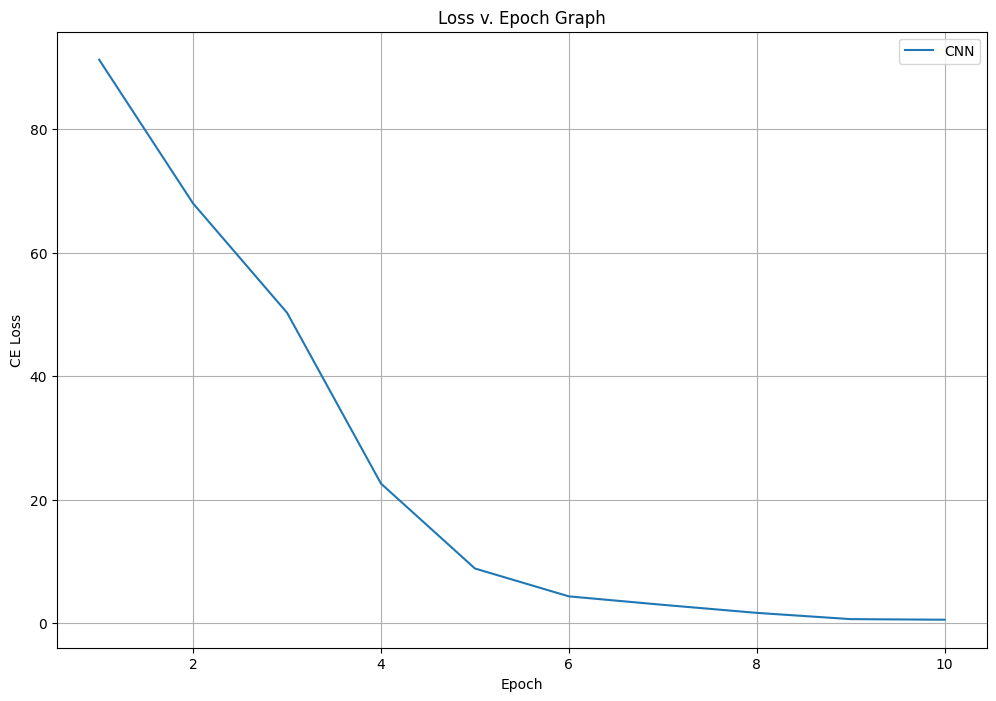

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Loss v. Epoch Graph
ax1.plot(range(1, epochSize+1), result['loss'], label="CNN")
ax1.legend()
ax1.grid()
ax1.set_title("Loss v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("CE Loss")

[]

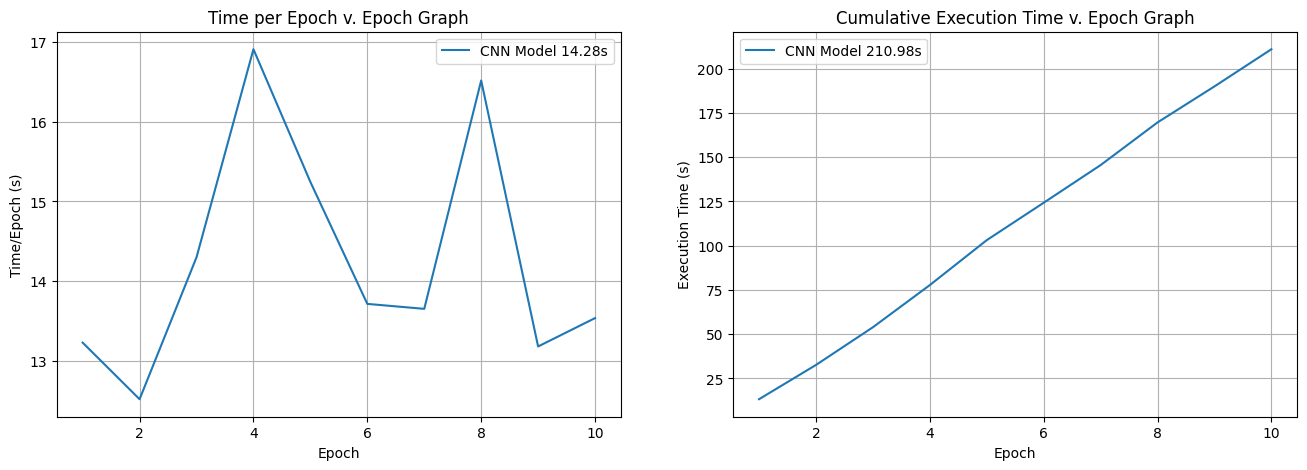

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Time per Epoch v. Epoch Graph
ax1.plot(range(1, epochSize+1), result['epoch_time'], label=f"CNN Model {np.mean(result['epoch_time']):.2f}s")
ax1.set_title("Time per Epoch v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Time/Epoch (s)")
ax1.legend()
ax1.grid()

# Time per Epoch v. Epoch Graph
ax2.plot(range(1, epochSize+1), result['exec_time'], label=f"CNN Model {result['exec_time'][-1]:.2f}s")
ax2.set_title("Cumulative Execution Time v. Epoch Graph")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Execution Time (s)")
ax2.legend()
ax2.grid()
plt.plot()

In [11]:
def evaluate_model(model, data_loader, model_name=""): #or def compute_accuracy():  , use whatever conventions that you like

    model.eval()

    train_loader, test_loader = data_loader[0], data_loader[1]

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Train Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Test Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")

evaluate_model(model, [train_loader, test_loader], "CNN")

CNN => Train Accuracy: 99.79% || Correct Labels: 932 / Wrong Labels: 2
CNN => Test Accuracy: 61.76% || Correct Labels: 84 / Wrong Labels: 52


Text(0.5, 1.0, 'CNN Accuracy v. Epoch')

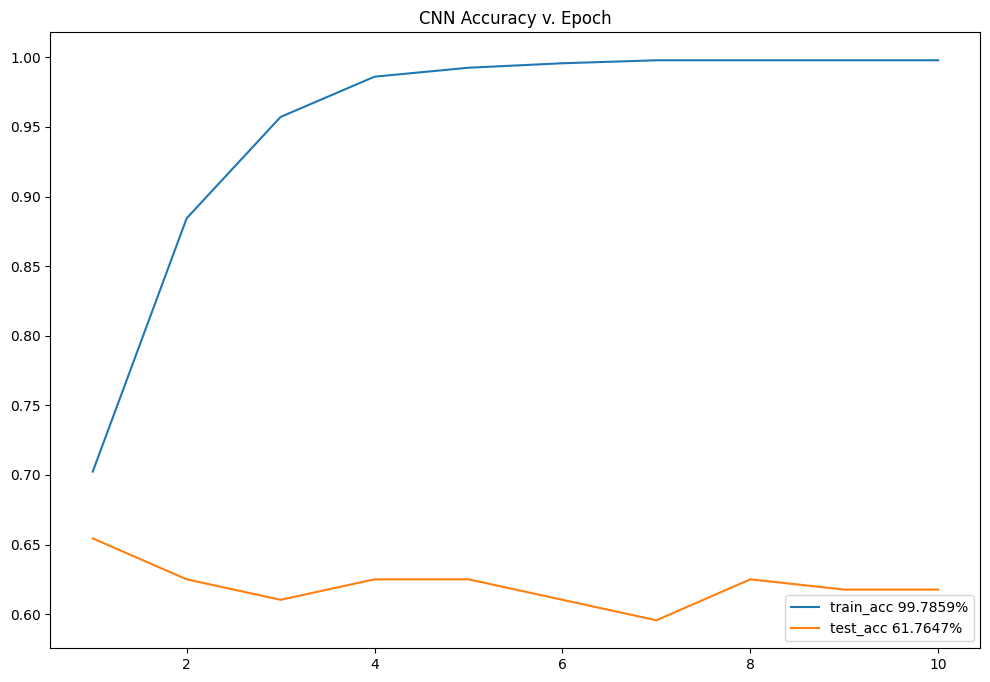

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Accuracy v. Epoch Graph
ax1.plot(range(1, epochSize+1), result['train_acc'], label=f"train_acc {result['train_acc'][-1]*100:.4f}%")
ax1.plot(range(1, epochSize+1), result['test_acc'], label=f"test_acc {result['test_acc'][-1]*100:.4f}%")
ax1.legend(loc='lower right')
ax1.set_title("CNN Accuracy v. Epoch")

In [13]:
# Save the model
torch.save(model.state_dict(), './models/brand_detect_modelv1.pth')
print("Saved!")

Saved!
